In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold , StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix ,roc_auc_score ,f1_score,classification_report
from sklearn.impute import KNNImputer

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV


from pytorch_tabnet.tab_model import TabNetClassifier
import matplotlib.pyplot as plt
import torch
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)


from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [2]:
cd Churn 


[WinError 123] The filename, directory name, or volume label syntax is incorrect: 'Churn \r'
F:\Cassava\Churn


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [4]:
train['Churn'] =  [0 if i =="No" else 1 for i in train['Churn'] ]

In [ ]:
## Descriptive Statistics 

In [176]:
train.groupby(['Churn']).agg({'TotalCharges':['mean','median'],'MonthlyCharges':['mean','median'],'tenure':['mean','median']}).reset_index()

Churn TotalCharges           MonthlyCharges             tenure       
                mean    median           mean  median       mean median
0     0  2529.181675  1643.400      60.889076  64.025  37.053851     36
1     1  1565.176742   762.175      74.481462  79.900  18.371080     10

In [178]:
train.groupby(['Churn','Contract']).agg({'TotalCharges':['mean','median'],'MonthlyCharges':['mean','median'],'tenure':['mean','median','count']}).reset_index()

Churn        Contract TotalCharges           MonthlyCharges          \
                                mean    median           mean  median   
0     0  Month-to-month  1497.874548   808.025      61.225720  64.925   
1     0        One year  2892.628145  2364.000      61.382460  62.850   
2     0        Two year  3667.487461  3571.600      60.034030  63.550   
3     1  Month-to-month  1196.656391   523.500      72.981099  79.225   
4     1        One year  4073.970408  4044.650      85.458242  94.350   
5     1        Two year  5471.946970  6144.550      85.932813  95.750   

      tenure               
        mean median count  
0  20.654367   16.0  1328  
1  41.534974   43.0   772  
2  56.057054   64.0   964  
3  14.382498    8.0  1017  
4  45.295918   49.5    98  
5  61.333333   66.0    33

In [209]:
train.Churn.value_counts()

0    3064
1    1148
Name: Churn, dtype: int64

In [220]:
train.groupby(['Churn','tenure_bin']).agg({'TotalCharges':['mean','median'],'MonthlyCharges':['mean','median']}).reset_index()

Churn tenure_bin TotalCharges           MonthlyCharges        
                            mean    median           mean  median
0      0          1          NaN       NaN      43.000000  25.350
1      0          2    37.879921    25.250      37.416514  25.000
2      0          3    92.783766    87.900      46.074265  45.325
3      0          4   154.979825   160.850      50.441667  50.325
4      0          5   219.102913   217.100      48.907895  50.300
5      0          6   417.163849   402.050      48.899012  50.300
6      0          7   801.656306   772.400      54.596985  55.200
7      0          8  3372.209580  2969.325      65.823114  70.550
8      1          2    57.337662    60.150      57.350469  60.150
9      1          3   123.528676   118.200      62.476271  68.950
10     1          4   197.158333   221.450      65.504082  75.500
11     1          5   311.538776   324.875      71.098851  76.650
12     1          6   637.296078   622.900      76.068519  80.500
13     1          7  1133.891892  1147.450      80.031188  84.600
14     1          8  3488.758199  3030.600      85.578149  90.200

In [180]:
train.Contract.value_counts(normalize=True)*100

Month-to-month    55.674264
Two year          23.670465
One year          20.655271
Name: Contract, dtype: float64

In [206]:
train.Churn.value_counts(normalize=True)*100

0    72.744539
1    27.255461
Name: Churn, dtype: float64

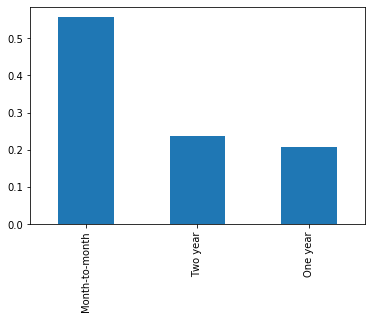

In [204]:
train.Contract.value_counts(normalize=True).plot.bar(y='percentage')

# Model Development

In [64]:
df = train.append(test)

In [65]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

In [66]:
# df = df.sample(frac=1).reset_index(drop=True)

In [67]:
# ## dropping the target variable
target = df['Churn']
df.drop(['Churn'],axis=1, inplace=True)

In [68]:
cat_cols = df.columns[df.dtypes== object]
num_cols = df.columns[df.dtypes!= object]

In [69]:
### converting the categorical columns to labels

print('Label Encoder...')

for col in tqdm(cat_cols):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
del le


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 477.61it/s]

Label Encoder...


In [70]:
imputer = KNNImputer(n_neighbors=20)
df_imputed = pd.DataFrame(imputer.fit_transform(df),columns=df.columns,index=df.index)

# Feature engineering 

In [72]:



df_imputed['tenure'] = df_imputed['tenure'].apply(lambda x: 0.5 if x==0 else x)
df_imputed['tenure_days'] = df_imputed['tenure']*30
# Create bins of or days in tenure
bins = [0,30,60,90,120,180,360,540]
df_imputed['tenure_bin']= np.digitize(df_imputed.tenure_days,bins)

df_imputed['total_charges_calc'] = df_imputed['MonthlyCharges']*df_imputed['tenure']
df_imputed['diff_total_charges'] = df_imputed['TotalCharges'] - df_imputed['total_charges_calc']

df_imputed['monthly_charges_calc']= df_imputed['TotalCharges']/df_imputed['tenure']
df_imputed['diff_monthly_charges'] = df_imputed['MonthlyCharges']- df_imputed['monthly_charges_calc']

df_imputed['charges_per_day_from_month'] = df_imputed['MonthlyCharges']/30
df_imputed['charges_per_day_from_total'] = df_imputed['TotalCharges']/df_imputed['tenure_days']
df_imputed['single'] = (df_imputed.Dependents + df_imputed.Partner == 0)*1

df_imputed['diff_charges_per_day']= df_imputed['charges_per_day_from_month'] -df_imputed['charges_per_day_from_total']
df_imputed['all_of_internet_services'] = df_imputed.OnlineSecurity + df_imputed.OnlineBackup + df_imputed.DeviceProtection + df_imputed.StreamingTV + df_imputed.StreamingMovies + df_imputed.TechSupport


In [73]:
## Feature engineering groupby features


for col in tqdm(['tenure_bin', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'all_of_internet_services',
       'Contract', 'PaperlessBilling', 'PaymentMethod']) :
    for cols in [ 'MonthlyCharges', 'TotalCharges']:
        df_imputed[cols+"_"+col+"_mean"] = df_imputed.groupby(col)[cols].transform('mean')
        df_imputed[cols+"_"+col+"_count"] = df_imputed.groupby(col)[cols].transform('count')
#         df[cols+"_"+col+"_sum"] = df.groupby(col)[cols].transform('sum')
        
        


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 268.68it/s]


In [74]:
df_imputed['Churn'] = target
df_imputed[cat_cols] = df_imputed[cat_cols].astype(int)

In [75]:
df_imputed.drop(['gender'],axis=1, inplace=True)

df_train = df_imputed[~df_imputed.Churn.isnull()]
df_test = df_imputed[df_imputed.Churn.isnull()]


In [231]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.018431,-0.218755,0.025223,-0.004625,0.152894,-0.036384,-0.121767,-0.000367,-0.032974,-0.159061,0.050436,0.046828,-0.136839,0.159340,-0.053205,0.232064,0.116250,0.130071
Partner,0.018431,1.000000,0.450529,0.379988,0.012371,0.144982,-0.004475,0.148978,0.138362,0.183674,0.134434,0.136705,0.139423,0.305503,-0.024143,-0.158986,0.100603,0.318846,-0.163311
Dependents,-0.218755,0.450529,1.000000,0.152354,-0.021254,-0.032364,0.044728,0.137849,0.074533,0.082724,0.129567,0.033368,0.013728,0.245016,-0.113844,-0.043352,-0.134437,0.048533,-0.166864
tenure,0.025223,0.379988,0.152354,1.000000,0.014047,0.341655,-0.024615,0.319470,0.364355,0.380608,0.327923,0.300119,0.303016,0.668328,0.004183,-0.356886,0.270253,0.830457,-0.340974
PhoneService,-0.004625,0.012371,-0.021254,0.014047,1.000000,-0.017107,0.385471,-0.008622,0.011699,0.003388,-0.014555,0.044317,0.037532,0.004539,0.015820,-0.012461,0.233180,0.111107,0.015068
MultipleLines,0.152894,0.144982,-0.032364,0.341655,-0.017107,1.000000,-0.100123,0.003102,0.120643,0.123154,0.005981,0.165824,0.186787,0.106881,0.166620,-0.166195,0.434549,0.446636,0.056418
InternetService,-0.036384,-0.004475,0.044728,-0.024615,0.385471,-0.100123,1.000000,-0.023326,0.035461,0.045766,-0.033635,0.102080,0.098709,0.106820,-0.139980,0.078537,-0.340691,-0.170358,-0.061099
OnlineSecurity,-0.121767,0.148978,0.137849,0.319470,-0.008622,0.003102,-0.023326,1.000000,0.193404,0.176358,0.287738,0.043949,0.058698,0.369026,-0.158488,-0.085621,-0.045416,0.250601,-0.283758
OnlineBackup,-0.000367,0.138362,0.074533,0.364355,0.011699,0.120643,0.035461,0.193404,1.000000,0.185109,0.184907,0.131655,0.132445,0.276039,-0.022147,-0.122324,0.112481,0.361800,-0.190661
DeviceProtection,-0.032974,0.183674,0.082724,0.380608,0.003388,0.123154,0.045766,0.176358,0.185109,1.000000,0.255657,0.270702,0.292235,0.357455,-0.041352,-0.133988,0.156285,0.394285,-0.184354


In [76]:
x_train ,x_test, y_train ,  y_test  =    train_test_split(df_train[df_train.columns.difference(['Churn'])], df_train['Churn'], test_size=0.15, stratify=df_train['Churn'])
# x_train ,x_valid, y_train ,  y_valid =  train_test_split(x_train, y_train, test_size=0.20, stratify=y_train)

df_train.drop(['Churn'],axis=1, inplace=True)
df_test.drop(['Churn'],axis=1, inplace=True)

## Base Models - Fine Tuning

#### catboost

In [20]:
model = CatBoostClassifier(iterations=2000,
#                              bagging_temperature = 0.2,
                           depth = 12,
                             use_best_model=True,
                           gpu_ram_part = .95,
                             random_seed=1993,
                           loss_function ="CrossEntropy",
                              eval_metric = "AUC",
                             task_type='GPU',
#                             l2_leaf_reg= 4, 
                        #    learning_rate = 0.03,
                             early_stopping_rounds=300,
                          verbose = 100)


In [56]:
categorical_column =np.where(x_train.columns.isin(cat_cols))[0]

In [22]:
cat_mod =  model.fit(x_train,y_train,cat_features=categorical_column,eval_set=(x_valid,y_valid))


0:	learn: 0.8394035	test: 0.8137422	best: 0.8137422 (0)	total: 236ms	remaining: 7m 52s
100:	learn: 0.9063416	test: 0.8321595	best: 0.8323370 (92)	total: 1m 7s	remaining: 21m 2s
200:	learn: 0.9386254	test: 0.8329026	best: 0.8331466 (148)	total: 2m 14s	remaining: 20m 7s
300:	learn: 0.9600590	test: 0.8310503	best: 0.8331466 (148)	total: 3m 23s	remaining: 19m 6s
400:	learn: 0.9730737	test: 0.8293756	best: 0.8331466 (148)	total: 4m 32s	remaining: 18m 6s
bestTest = 0.8331466317
bestIteration = 148
Shrink model to first 149 iterations.


In [23]:
sorted(zip(cat_mod.feature_importances_,x_train.columns),reverse=True) 

[(12.76503338239249, 'tenure'),
 (8.461541248289384, 'TotalCharges'),
 (5.907858671570182, 'Contract'),
 (5.716251669757835, 'MonthlyCharges'),
 (4.531815628382477, 'PaymentMethod'),
 (4.394008809120431, 'InternetService'),
 (4.382739574284412, 'TechSupport'),
 (4.1304534624460505, 'StreamingMovies'),
 (3.83814589566943, 'OnlineSecurity'),
 (3.588616058458469, 'MultipleLines'),
 (3.3135531793880886, 'StreamingTV'),
 (2.948685226637699, 'DeviceProtection'),
 (2.1727486723910183, 'OnlineBackup'),
 (1.8792905245969547, 'TotalCharges_PaperlessBilling_count'),
 (1.5596177672350608, 'tenure_Contract_count'),
 (1.4844030550336813, 'tenure_InternetService_count'),
 (1.3522276980524288, 'TotalCharges_Contract_mean'),
 (1.2990424110284853, 'MonthlyCharges_Contract_mean'),
 (1.1665521059099007, 'tenure_PaperlessBilling_mean'),
 (1.040081442144385, 'TotalCharges_Contract_count'),
 (1.0239029147537395, 'MonthlyCharges_PaperlessBilling_mean'),
 (1.0162313636129774, 'tenure_StreamingMovies_mean'),
 (

In [26]:
sorted(zip(cat_mod.feature_importances_,x_train.columns),reverse=True) 

[(18.522936175846475, 'Contract'),
 (17.053857616988566, 'tenure'),
 (13.64714520978379, 'TotalCharges'),
 (13.644775283807467, 'InternetService'),
 (7.731561515674626, 'TechSupport'),
 (7.44171269771672, 'PaymentMethod'),
 (7.284868016668111, 'OnlineSecurity'),
 (5.785298929026023, 'MonthlyCharges'),
 (2.634943596495006, 'PaperlessBilling'),
 (2.2269342524867657, 'StreamingMovies'),
 (1.4820160361344885, 'OnlineBackup'),
 (1.0170259445554615, 'StreamingTV'),
 (0.9211028009469464, 'MultipleLines'),
 (0.6058219238695901, 'DeviceProtection'),
 (0.0, 'gender'),
 (0.0, 'SeniorCitizen'),
 (0.0, 'PhoneService'),
 (0.0, 'Partner'),
 (0.0, 'Dependents')]

In [24]:
pred =cat_mod.predict(x_test)

In [25]:
print(f' ROC AUC Score  : {roc_auc_score( y_test,cat_mod.predict_proba(x_test)[:,1] )}')
print(f' F1 Score : {f1_score(pred,y_test)}')
print(f" Accuracy Score : {accuracy_score(pred,y_test)}")

 ROC AUC Score  : 0.8667104049932619
 F1 Score : 0.6
 Accuracy Score : 0.800711743772242


In [25]:
print(f' ROC AUC Score  : {roc_auc_score( y_test,cat_mod.predict_proba(x_test)[:,1] )}')
print(f' F1 Score : {f1_score(pred,y_test)}')
print(f" Accuracy Score : {accuracy_score(pred,y_test)}")

 ROC AUC Score  : 0.8560500744733668
 F1 Score : 0.6258823529411764
 Accuracy Score : 0.8113879003558719


In [22]:
# LightGBM

In [26]:
params = {
            'objective': 'cross_entropy',
            'learning_rate' : 0.03, 
#             'max_depth' : 12, 
            'metric': 'auc',
            'seed': 7,
            'verbose': 100,
            'boosting_type' : 'goss'
        }

lbgm_mod = lgb.train(params,
                lgb.Dataset(x_train,y_train),
                categorical_feature=cat_cols.to_list(),
                num_boost_round=1000,
                valid_sets=lgb.Dataset(x_valid,y_valid),
                verbose_eval=50,
                early_stopping_rounds=300)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Contract', 'Dependents', 'DeviceProtection', 'InternetService', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'Partner', 'PaymentMethod', 'PhoneService', 'SeniorCitizen', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'gender']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds
[50]	valid_0's auc: 0.825288
[100]	valid_0's auc: 0.8189
[150]	valid_0's auc: 0.813432
[200]	valid_0's auc: 0.809317
[250]	valid_0's auc: 0.806788
[300]	valid_0's auc: 0.804026
Early stopping, best iteration is:
[29]	valid_0's auc: 0.82744


In [27]:
pred_lgbm = [1 if x > 0.5 else 0 for x in lbgm_mod.predict(x_test) ]

In [292]:
confusion_matrix(pred_lgbm,y_test)

array([[564, 121],
       [ 49, 109]], dtype=int64)

In [28]:
print(f' ROC AUC Score  : {roc_auc_score(y_test,lbgm_mod.predict(x_test) )}')
print(f' F1 Score : {f1_score(y_test,pred_lgbm)}')
print(f" Accuracy Score : {accuracy_score(y_test,pred_lgbm)}")

 ROC AUC Score  : 0.8535392581034116
 F1 Score : 0.4506172839506173
 Accuracy Score : 0.7888493475682088


## Tabnet 

In [401]:

cat_idxs = [ i for i in np.where(x_train.columns.isin(cat_cols[1:]))[0]]

cat_dims =[ df_train[col].nunique() for col  in cat_cols[1:] ]

In [407]:
classifier = TabNetClassifier(verbose=0,seed=42,
                              cat_idxs=cat_idxs,
                              cat_dims=cat_dims,
                              cat_emb_dim=1)



In [403]:
classifier

TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=42, clip_value=1, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='auto')

In [404]:
classifier.fit(X_train=x_train.values, y_train=y_train.values,
               eval_set=[(x_train.values, y_train.values), (x_valid.values, y_valid.values)],
               eval_name=['train', 'valid'],eval_metric=['auc'],
               batch_size=512,virtual_batch_size=128,num_workers=0,drop_last=False,
               patience=5,max_epochs=100)


Early stopping occurred at epoch 11 with best_epoch = 6 and best_valid_auc = 0.73057
Best weights from best epoch are automatically used!


In [405]:

predictions = classifier.predict_proba(x_test.values)[:,1]

In [406]:

print(f' ROC AUC Score  : {roc_auc_score(y_test,predictions )}')

 ROC AUC Score  : 0.7539623356926188


In [40]:

# classifier = TabNetClassifier(
#     n_d=64, ncat_idxs=cat_idxs,
#     cat_dims=cat_dims,
#     cat_emb_dim=1,_a=64, n_steps=5,
#     gamma=1.5, n_independent=2, n_shared=2,
    
#     lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
#     optimizer_fn=torch.optim.Adam,
#     optimizer_params=dict(lr=2e-2),
#     scheduler_params = {"gamma": 0.95,
#                      "step_size": 20},
#     scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
# )

# Stacking 


In [77]:
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
base_test = df_test.shape[0]
SEED = 1993 # for reproducibility
NFOLDS = 3  #set folds for out-of-fold prediction
kf = StratifiedKFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)

In [3]:
def calibrate_model(model_obj,data, target,test,method="isotonic"):
    model = CalibratedClassifierCV(model_obj, cv=3, method=method) 
    model.fit(data, target)
    y_test_predict_proba = model.predict_proba(test)[:, 1]
    return y_test_predict_proba



def get_oof(clf, x_train, y_train, x_test,final_test,model=None,params=None,categorical_features=None):
    oof_train = np.zeros((x_train.shape[0],))
    oof_test = np.zeros((ntest,))
    test =  np.empty((NFOLDS,final_test.shape[0]))
    oof_test_skf = np.empty((NFOLDS, ntest))
    final_test = final_test[x_train.columns]
    clf = clf(**params)
        
    if categorical_features is not None:
        cat_idx = np.where(x_train.columns.isin(categorical_features))[0]
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train,y_train)):
        x_tr,x_te  = x_train.iloc[train_index],x_train.iloc[test_index]
        y_tr,y_te = y_train.iloc[train_index],y_train.iloc[test_index]
         
        if model == 'lightgbm':
            print(f'{model} : Running !')
            clf.fit(x_tr,y_tr,eval_set=[(x_te,y_te)],early_stopping_rounds=300,verbose=100)
            
        elif model == 'catboost':
            print(f'{model} : Running !')
            clf.fit(x_tr,y_tr,eval_set=(x_te,y_te),early_stopping_rounds=300,verbose=50,cat_features=cat_idx)
        elif model == 'xgboost':
            print(f'{model} : Running !')
            clf.fit(x_tr,y_tr,eval_set=[(x_te,y_te)],early_stopping_rounds=300,verbose=50)
        else:
            print(f'{model} : Running !')
            clf.fit(x_tr, y_tr)

        
        oof_train[test_index] = clf.predict_proba(x_te)[:,1]
        print("AUC score is ",roc_auc_score(y_te,clf.predict_proba(x_te)[:,1]))
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:,1]

        test[i, :] = clf.predict_proba(final_test)[:,1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    test = test.mean(axis=0)
    
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), test 

In [79]:
catboost_params = {'n_estimators':300,'random_state' :1993,'eval_metric':'AUC','verbose' : 100,'task_type':'GPU','early_stopping_rounds':300}

lgb_params = {'objective': 'cross_entropy','learning_rate' : 0.03,'num_boost_round':1000,
#               'max_depth' : 12, 
                'metric': 'auc',
                'seed': 7,
                'verbose': 100,
                'boosting_type' : 'goss'
               }



xg_params = {'train_method':'hist','nthread':4,'eval_metric':'auc','eta':0.05,'seed':1993,'objective':'binary:logitraw','grow_policy':'lossguide'} 


et_params = { 'n_jobs': -1, 'n_estimators':200,'verbose': 1}

rf_params = { 'n_jobs': -1,'n_estimators': 300,'max_depth': 12,'criterion': 'gini'}

lr_params = {'random_state':1993}


In [80]:
lgb_oof_train, lgb_oof_test ,lgb_test  = get_oof(LGBMClassifier,x_train, y_train, x_test,df_test,model="lightgbm",params=lgb_params,categorical_features=cat_cols[1:]) 

lightgbm : Running !
Training until validation scores don't improve for 300 rounds
[100]	valid_0's auc: 0.831573
[200]	valid_0's auc: 0.82119
[300]	valid_0's auc: 0.813288
Early stopping, best iteration is:
[61]	valid_0's auc: 0.836823
AUC score is  0.8368225382375393
lightgbm : Running !
Training until validation scores don't improve for 300 rounds
[100]	valid_0's auc: 0.825721
[200]	valid_0's auc: 0.82178
[300]	valid_0's auc: 0.820432
Early stopping, best iteration is:
[61]	valid_0's auc: 0.832093
AUC score is  0.8320932293512938
lightgbm : Running !
Training until validation scores don't improve for 300 rounds
[100]	valid_0's auc: 0.822834
[200]	valid_0's auc: 0.813779
[300]	valid_0's auc: 0.806756
Early stopping, best iteration is:
[61]	valid_0's auc: 0.825436
AUC score is  0.825436015597306


In [81]:
cb_oof_train, cb_oof_test,cb_test = get_oof(CatBoostClassifier,x_train, y_train, x_test,df_test,model="catboost",params=catboost_params,categorical_features=cat_cols[1:]) 

catboost : Running !
Learning rate set to 0.108867
0:	learn: 0.8391408	test: 0.8207200	best: 0.8207200 (0)	total: 25.2ms	remaining: 7.53s
50:	learn: 0.9093057	test: 0.8375382	best: 0.8419097 (26)	total: 1.42s	remaining: 6.96s
100:	learn: 0.9407887	test: 0.8366670	best: 0.8419097 (26)	total: 2.9s	remaining: 5.72s
150:	learn: 0.9609429	test: 0.8322037	best: 0.8419097 (26)	total: 4.38s	remaining: 4.32s
200:	learn: 0.9754537	test: 0.8279381	best: 0.8419097 (26)	total: 5.84s	remaining: 2.88s
250:	learn: 0.9847616	test: 0.8270299	best: 0.8419097 (26)	total: 7.32s	remaining: 1.43s
299:	learn: 0.9915411	test: 0.8262277	best: 0.8419097 (26)	total: 8.81s	remaining: 0us
bestTest = 0.8419096768
bestIteration = 26
Shrink model to first 27 iterations.
AUC score is  0.8419096859008792
catboost : Running !
Learning rate set to 0.108863
0:	learn: 0.8453434	test: 0.7864410	best: 0.7864410 (0)	total: 23.3ms	remaining: 6.95s
50:	learn: 0.9082509	test: 0.8354307	best: 0.8375771 (33)	total: 1.42s	remaining:

In [130]:
xg_oof_train, xg_oof_test,xg_test= get_oof(XGBClassifier,x_train, y_train, x_test,df_test,model="xgboost",params=xg_params,categorical_features=cat_cols) 

xgboost : Running !
[0]	validation_0-auc:0.79968
Will train until validation_0-auc hasn't improved in 300 rounds.
[50]	validation_0-auc:0.81962
[99]	validation_0-auc:0.82200
AUC score is  0.8227237708857537
xgboost : Running !
[0]	validation_0-auc:0.79414
Will train until validation_0-auc hasn't improved in 300 rounds.
[50]	validation_0-auc:0.82298
[99]	validation_0-auc:0.82217
AUC score is  0.8271481744062389
xgboost : Running !
[0]	validation_0-auc:0.79947
Will train until validation_0-auc hasn't improved in 300 rounds.
[50]	validation_0-auc:0.81889
[99]	validation_0-auc:0.82043
AUC score is  0.8220258773484579


In [112]:

# et_oof_train, et_oof_test,et_test ,et_iso = get_oof(ExtraTreesClassifier,x_train, y_train, x_test,df_test,model="extratrees",params=et_params,categorical_features=cat_cols) 

extratrees : Running !


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


AUC score is  0.8078616663368294


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks

extratrees : Running !


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


AUC score is  0.7822048918823112


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend Threading

extratrees : Running !


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


AUC score is  0.7835962424672103


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks

In [83]:
rf_oof_train, rf_oof_test ,rf_test = get_oof(RandomForestClassifier,x_train, y_train, x_test,df_test,model="randomforest",params=rf_params) 

randomforest : Running !
AUC score is  0.827105891832292
randomforest : Running !
AUC score is  0.8205494505494506
randomforest : Running !
AUC score is  0.8123980857851827


In [84]:
lr_oof_train, lr_oof_test ,lr_test  = get_oof(LogisticRegression,x_train, y_train, x_test,df_test,model="logistic",params=lr_params) 

logistic : Running !
AUC score is  0.8390171326793137
logistic : Running !
AUC score is  0.8234686281460475
logistic : Running !
AUC score is  0.829432825239277


In [244]:
# from sklearn.metrics import roc_curve
# import matplotlib.pyplot as plt

# # Compute False postive rate, and True positive rate
# fpr, tpr, _ = roc_curve(target_test,final_pred,pos_label=2 )
# fpr1, tpr1, _  = roc_curve(target_test,pred1,pos_label=2 )
# fpr2, tpr2, _  = roc_curve(target_test,pred2,pos_label=2 )
# fpr3, tpr3, _  = roc_curve(target_test,pred3,pos_label=2 )
# fpr4, tpr4, _  = roc_curve(target_test,pred4,pos_label=2 )
# fpr5, tpr5, _  = roc_curve(target_test,finalpred,pos_label=2 )



# # Calculate Area under the curve to display on the plot
# auc = roc_auc_score(target_test, final_pred)
# plt.plot(fpr,tpr,label="Ensemble mean, auc="+str(auc))
# plt.plot(fpr1,tpr1,lw=1,label="logistic, auc="+str(roc_auc_score(target_test, pred1)))
# plt.plot(fpr2,tpr2,label="random forest, auc="+str(roc_auc_score(target_test, pred2)))
# plt.plot(fpr3,tpr3,label="catboost, auc="+str(roc_auc_score(target_test, pred3)))
# plt.plot(fpr4,tpr4,label="Kfold_catboost, auc="+str(roc_auc_score(target_test, pred4)))
# plt.plot(fpr5,tpr5,label="Weighted AVG, auc="+str(roc_auc_score(target_test, finalpred)))


# # Custom settings for the plot 
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('1-Specificity(False Positive Rate)')
# plt.ylabel('Sensitivity(True Positive Rate)')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc=4)
# plt.show()

In [133]:
#### Model 2 :
base_predictions_train = pd.DataFrame( {'lightgbm': lgb_oof_train.ravel(),
     'catboost': cb_oof_train.ravel(),
#      'xgboost': xg_oof_train.ravel(),
#      'extratrees':et_oof_train.ravel(),
     'randomforest':rf_oof_train.ravel(),
     'logisticregression':lr_oof_train.ravel()
                                  
    })

In [167]:
corr = base_predictions_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,lightgbm,catboost,xgboost,randomforest,logisticregression
lightgbm,1.000000,0.947435,0.929034,0.940445,0.916956
catboost,0.947435,1.000000,0.917198,0.932704,0.955287
xgboost,0.929034,0.917198,1.000000,0.917488,0.888168
randomforest,0.940445,0.932704,0.917488,1.000000,0.908244
logisticregression,0.916956,0.955287,0.888168,0.908244,1.000000


In [88]:
(roc_auc_score(y_test,rf_oof_test),roc_auc_score(y_test,lgb_oof_test),roc_auc_score(y_test,cb_oof_test),roc_auc_score(y_test,xg_oof_test))

(0.8400910010111224, 0.851706268958544, 0.8538928210313447, 0.8457785642062688)

In [134]:
base_test =pd.DataFrame( {'lightgbm': lgb_oof_test.ravel(),
     'catboost': cb_oof_test.ravel(),
#      'xgboost': xg_oof_test.ravel(),
#      'extratrees':et_oof_test.ravel(),
     'randomforest': rf_oof_test.ravel(),
     'logisticregression':lr_oof_test.ravel()                     
    })

In [135]:
final_pred =pd.DataFrame( {'lightgbm': lgb_test.ravel(),
     'catboost': cb_test.ravel(),
#      'xgboost': xg_test.ravel(),
#      'extratrees':et_test.ravel(),
     'randomforest': rf_test.ravel(),
     'logisticregression':lr_test.ravel()                     
    })

In [136]:
clf_lr = LogisticRegression(random_state=0).fit(base_predictions_train, y_train)
predictions_model_level1=clf_lr.predict_proba(base_test)[:,1]

In [137]:
# Calibrated
clf_sigmoid = CalibratedClassifierCV(clf_lr, cv=3, method='isotonic')
clf_sigmoid.fit(base_predictions_train, y_train)
predictions_model_level1_iso = clf_sigmoid.predict_proba(base_test)[:, 1]

In [292]:
#18 vars ~~ 0.8614582594510249 auc roc

In [138]:
roc_auc_score(y_test,predictions_model_level1),roc_auc_score(y_test,predictions_model_level1_iso)

(0.8563195146612739, 0.8556370070778564)

In [127]:
final_pred = clf_lr.predict_proba(final_pred)[:,1]

# Blending

In [139]:
from scipy.optimize import fmin
from functools import partial

In [140]:
class OptimizeAUC:
    def __inti__(self):
        self.coeff = None
        
    def loss_function(self, coeff,data, target):
        data_coeff = data * coeff
        prediction = np.sum(data_coeff,axis=1)
        auc_score = roc_auc_score(target, prediction)
        return -1 * auc_score
        
    
    def fit(self, data, target):
        partial_loss = partial(self.loss_function,data=data, target=target)
        init_coeff = np.random.dirichlet(np.ones(data.shape[1]))
        self.coeff = fmin(partial_loss, init_coeff, disp=True)
        
    def predict(self,data):
        data_coeff = data *self.coeff
        prediction = np.sum(data_coeff,axis=1)
        return prediction 
        

In [141]:
opt = OptimizeAUC()

In [142]:
opt.fit(base_test,y_test)

Optimization terminated successfully.
         Current function value: -0.854879
         Iterations: 51
         Function evaluations: 113


In [143]:
preds = opt.predict(base_test)

In [144]:
roc_auc_score(y_test,preds)

0.8548786653185036

### check model calibration 

In [155]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test.values, base_test.catboost.values, n_bins=10,normalize=True)

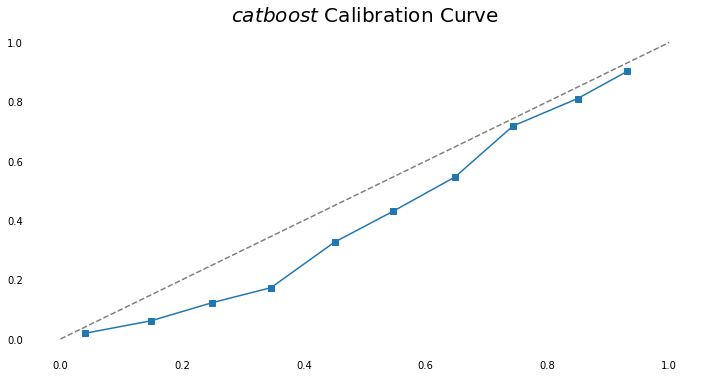

In [154]:
import seaborn as sns
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$catboost$ Calibration Curve", fontsize=20); pass

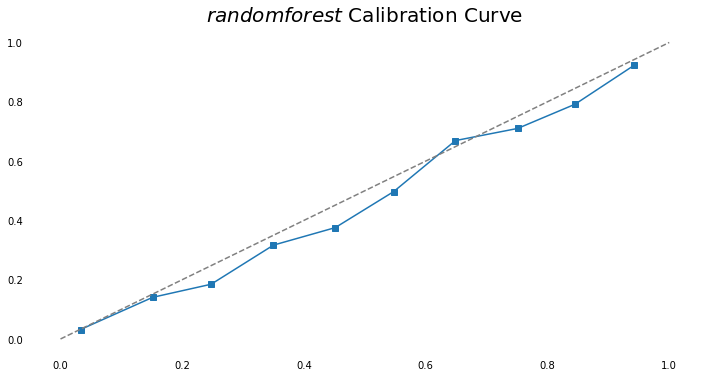

In [156]:
import seaborn as sns
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$randomforest$ Calibration Curve", fontsize=20); pass

In [4]:
# Prediction

In [ ]:
final_pred.to_csv('final_predictions.csv',index=False)